<a href="https://colab.research.google.com/github/dolmani38/concept_drift/blob/main/230820_AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Concept drift tolerant machine learning method

In [1]:
import numpy as np
import pandas as pd
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
import random
import os
def seed_everything(seed: int = 46):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    #tf.random.set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)

# 실험을 위한 기본적인 function 들...

In [290]:
import sys, os
import math

from torch.autograd import Variable
from argparse import Namespace
#from FRTrain_arch import Generator, DiscriminatorF, DiscriminatorR, weights_init_normal, test_model
#from FRTrain_arch import weights_init_normal, test_model
import warnings
warnings.filterwarnings("ignore")

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

In [291]:
main_figsize=(15,3)

plt.rc('font', size=10)        # 기본 폰트 크기
plt.rc('axes', labelsize=10)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=10)  # x축 눈금 폰트 크기
plt.rc('ytick', labelsize=10)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize=10)  # 범례 폰트 크기
plt.rc('figure', titlesize=10) # figure title 폰트 크기


In [292]:
def weights_init_normal(m):
    """Initializes the weight and bias of the model.

    Args:
        m: A torch model to initialize.

    Returns:
        None.
    """

    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find('Linear') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.2)
        torch.nn.init.constant_(m.bias.data, 0)


In [293]:
# Define the Generator
# bucket에 대해 x를 전처리
class Generator(nn.Module):

    def __init__(self,input_dim):
        super(Generator, self).__init__()

        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        #self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(2, self.input_dim*10))
            #self.fc2.append(nn.BatchNorm1d(num_features=50))
            self.fc3.append(nn.Linear(self.input_dim*10, 1))

        #self.fc = nn.Linear(input_dim, input_dim)

    def forward(self,x,b):
        pxy = []
        for i in range(self.input_dim):
            h0 = self.fc1[i](torch.cat((x[:,i].reshape(-1,1),b), 1))
            #h1 = F.relu(self.fc2[i](h0))
            #h2 = self.fc3[i](h1)
            h2 = self.fc3[i](F.relu(h0))
            pxy.append(h2)

        #return self.fc(torch.tensor(torch.cat(pxy, dim=1), requires_grad = True))
        return torch.cat(pxy, dim=1)


In [294]:
# Define the Discriminator
# 비즈니스에 해당하는 모델
class Discriminator(nn.Module):

    def __init__(self, input_dim=5):
        """Initializes Discriminator with torch components."""
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, input_dim*4),
            nn.ReLU(),
            nn.Linear(input_dim*4, input_dim),
            nn.ReLU(),
            nn.Linear(input_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output


class Discriminator2(nn.Module):
    """FR-Train generator (classifier).

    This class is for defining the structure of FR-Train generator (classifier).
    (ref: FR-Train paper, Section 3)

    Attributes:
        model: A model consisting of torch components.
    """

    def __init__(self):
        """Initializes Generator with torch components."""
        super(Discriminator2, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(5, 20),
            nn.ReLU(),
            nn.Linear(20, 5),
            nn.ReLU(),
            nn.Linear(5, 1),
            nn.Sigmoid()
        )

    def forward(self, input_data):
        """Defines a forward operation of the model.

        Args:
            input_data: The input data.

        Returns:
            The predicted label (y_hat) for the given input data.
        """

        output = self.model(input_data)
        return output

In [295]:
from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
import scipy

def test_model(model_,model2_, train_tensors, test_tensors, avaible_range,columns):
    device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test

    model_.eval()

    b_dim = XS_test.shape[1]-1

    #test_analysis = {}
    XS = XS_train[:,b_dim].cpu().data.numpy()
    '''
    for bk in np.unique(XS,axis = 0):
        test_analysis[f'Sum(MI{bk})']= []
        test_analysis[f'Std(MI{bk})']= []
        test_analysis[f'Ent(MI{bk})']= []

        test_analysis[f'Sum(DR{bk})']= []
        test_analysis[f'Std(DR{bk})']= []
        test_analysis[f'Ent(DR{bk})']= []

    test_analysis['TrainSum(MI)']= []
    test_analysis['TrainStd(MI)']= []
    test_analysis['TrainEnt(MI)']= []

    test_analysis['Test Sum(MI)']= []
    test_analysis['Test Std(MI)']= []
    test_analysis['Test Ent(MI)']= []

    test_analysis['Test Sum(DR)']= []
    test_analysis['Test Std(DR)']= []
    test_analysis['Test Ent(DR)']= []
    '''
    if model2_ == None:
        ax = XS_test
        ref_ax = XS_train
    else:
        model2_.eval()
        ax = model2_(XS_test[:,0:b_dim],XS_test[:,b_dim].reshape(-1,1)/avaible_range)
        ref_ax = model2_(XS_train[:,0:b_dim],XS_train[:,b_dim].reshape(-1,1)/avaible_range)

    y_hat = model_(ax)
    y_hat = (y_hat.cpu().data.numpy()> 0.5).astype(float)

    ty_ = y_test.data.numpy()
    f1 = f1_score(ty_,y_hat)
    '''
    #################### Test (f(x'),y) #########################
    ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
    #test_analysis['Test Sum(MI)'].append(np.sum(mi_scores))
    #test_analysis['Test Std(MI)'].append(np.std(mi_scores))
    #test_analysis['Test Ent(MI)'].append(scipy.stats.entropy(mi_scores))

    ks = __ks_drift(ax_df.values,XS_test[:,0:b_dim].cpu().data.numpy())
    #test_analysis['Test Sum(DR)'].append(np.sum(ks[:,0]))
    #test_analysis['Test Std(DR)'].append(np.std(ks[:,0]))
    #test_analysis['Test Ent(DR)'].append(scipy.stats.entropy(ks[:,0]))

    #################### Train (f(x'),y) #########################
    ax_df = pd.DataFrame(ref_ax.cpu().data.numpy(),columns=columns)
    mi_scores = make_mi_scores(ax_df, y_train.data.numpy(), discrete_features="auto")
    #test_analysis['TrainSum(MI)'].append(np.sum(mi_scores))
    #test_analysis['TrainStd(MI)'].append(np.std(mi_scores))
    #test_analysis['TrainEnt(MI)'].append(scipy.stats.entropy(mi_scores))

    #################### Train (f(x'_b),y_b) #########################
    '''
    '''
    for bk in np.unique(XS,axis = 0):
        inx = np.where(XS==bk)[0]
        #print(XS_train[:,b_dim].cpu().data.numpy())
        if model2_ == None:
            ax = XS_train[inx][:,0:b_dim]
        else:
            ax = model2_(XS_train[inx][:,0:b_dim],XS_train[inx][:,b_dim].reshape(-1,1)/avaible_range)


        ty_ = y_train[inx].data.numpy()

        ax_df = pd.DataFrame(ax.cpu().data.numpy(),columns=columns)
        mi_scores = make_mi_scores(ax_df, ty_, discrete_features="auto")
        #test_analysis[f'Sum(MI{bk})'].append(np.sum(mi_scores))
        #test_analysis[f'Std(MI{bk})'].append(np.std(mi_scores))
        #test_analysis[f'Ent(MI{bk})'].append(scipy.stats.entropy(mi_scores))

        ks = __ks_drift(XS_train[:,0:b_dim].cpu().data.numpy(),ax_df.values)
        #test_analysis[f'Sum(DR{bk})'].append(np.sum(ks[:,0]))
        #test_analysis[f'Std(DR{bk})'].append(np.std(ks[:,0]))
        #test_analysis[f'Ent(DR{bk})'].append(scipy.stats.entropy(ks[:,0]))
    '''
    print("Test f1 score: {}".format(f1))

    #test_analysis_df = pd.DataFrame(test_analysis)
    #print(test_analysis_df)

    return f1#,test_analysis_df

In [296]:

def test_all_data(discriminator,generator,X_train, X_live, Y_live, train_size, test_size, avaible_range, columns, ShowChart = False,bucket_size_array=[200]):

    device = "cpu" # torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    print('X_live.shape',X_live.shape)

    b_dim = X_live.shape[1]-1
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        #xl = X_live[i*test_size:i*test_size+test_size]
        #yl = Y_live[i*test_size:i*test_size+test_size]
        if len(xl) ==  train_size:
        #if len(xl) ==  test_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break


    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set),dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []
    MISS = {}
    DRF = {}
    for col in columns:
        MISS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        if generator == None:
            xs = X_live_unit
        else:
            xs = generator(X_live_unit[:,0:b_dim],X_live_unit[:,b_dim].reshape(-1,1)/avaible_range)
        predicted_y = discriminator(xs)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        #r2 = r2_score(yT[bk*bucket_count:bk*bucket_count+bucket_count],predicted_y.detach().numpy())
        f1s.append(f1_)

        cpu_xs = xs.cpu().data.numpy()
        #mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), Y_live_unit, discrete_features="auto")
        mi_scores = make_mi_scores(pd.DataFrame(cpu_xs,columns=columns), predicted_y, discrete_features="auto")
        ks = __ks_drift(X_train.values,cpu_xs)
        for ix,col in enumerate(columns):
            MISS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MISS)
    df_drf = pd.DataFrame(DRF)

    if ShowChart:
        plt.figure(figsize=main_figsize)
        plt.plot(f1s,linewidth=1)
        plt.ylabel('F1 Score')
        plt.xlabel(f'bucket ({test_size})')
        plt.show()

        df_mis.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

        df_drf.plot(figsize=main_figsize,linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})',fontsize=15)
        plt.legend(loc=1)
        plt.show()

    print(f'mean of drift:\n{df_drf.mean()}')
    print('Mean F1 for all data:',np.mean(f1s))

    return f1s, df_mis, df_drf

In [297]:
H=20

class Net(nn.Module):
    def __init__(self,input_dim):
        super(Net, self).__init__()
        self.input_dim = input_dim
        self.fc1 = nn.ModuleList()
        self.fc2 = nn.ModuleList()
        self.fc3 = nn.ModuleList()
        #self.fc4 = nn.ModuleList()

        for i in range(self.input_dim):
            self.fc1.append(nn.Linear(1, H))
            self.fc2.append(nn.Linear(1, H))
            self.fc3.append(nn.Linear(H, 1))

    def forward(self, x, y):
        h = []
        for i in range(self.input_dim):
            h0 = F.relu(self.fc1[i](x[:,i].reshape(-1,1))+self.fc2[i](y.reshape(-1,1)))
            h1 = self.fc3[i](h0)
            h.append(h1)

        mi = torch.cat(h, dim=1)
        return mi

class customLoss(nn.Module):
    def __init__(self, model):
        super(customLoss, self).__init__()
        self.model = model

    def forward(self, x,y):
        minibatch = int(x.shape[0] * 0.8)
        s = np.random.choice(x.shape[0],minibatch)
        #x_sample = Variable(torch.from_numpy(x[s,:]).type(torch.FloatTensor), requires_grad = True)
        #y_sample = Variable(torch.from_numpy(y[s]).type(torch.FloatTensor), requires_grad = True)
        #y_shuffle = Variable(torch.from_numpy(np.random.permutation(y[s])).type(torch.FloatTensor), requires_grad = True)
        x_sample = x[s,:] #Variable(x[s,:], requires_grad = True)
        y_sample = y[s] #Variable(, requires_grad = True)
        y_shuffle = y[torch.randperm(minibatch)] #Variable(, requires_grad = True)
        p_xy = self.model(x_sample, y_sample)
        p_x_y = self.model(x_sample, y_shuffle)
        ret = torch.mean(p_xy,0) - torch.log(torch.mean(torch.exp(p_x_y),0))
        loss = - ret

        return loss #, ret.sum().reshape(-1,)

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2

In [298]:
# 본래의 FR-Train에서, Robustness Discriminator를 삭제 하였으므로,  val_tensors, lambda_r 를 삭제 한다.

def train_model(train_tensors, test_tensors, train_opt, lambda_f, avaible_range, alpha, columns,ShowChart = False, do_mine=True):
    #seed_everything()

    device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)

    #lambda_f = torch.tensor([lambda_f],dtype=torch.float32).to(device)

    XS_train = train_tensors.XS_train.to(device)
    y_train = train_tensors.y_train.to(device)
    #s1_train = train_tensors.s1_train.to(device)

    XS_test = test_tensors.XS_test.to(device)
    y_test = test_tensors.y_test.to(device)
    #s1_test = test_tensors.s1_test.to(device)

    # Saves return values here
    #test_result = []

    val = train_opt.val # Number of data points in validation set
    k = train_opt.k     # Update ratio of generator and discriminator (1:k training).
    n_epochs = train_opt.n_epochs  # Number of training epoch

    b_dim = XS_train.shape[1]-1

    # The loss values of each component will be saved in the following lists.
    # We can draw epoch-loss graph by the following lists, if necessary.
    g_losses =[]
    a_losses = []
    m_losses =[]
    f_losses = []

    bce_loss = nn.BCELoss()
    mse_loss = nn.MSELoss() #reduce=False)  # mean square error

    # Initializes generator and discriminator
    discriminator = Discriminator2().to(device)

    # Initializes weights
    torch.manual_seed(1)
    discriminator.apply(weights_init_normal)

    optimizer_G = torch.optim.Adam(discriminator.parameters(), lr=train_opt.lr_g)

    train_len = XS_train.shape[0]

    mine2 = Net2().to(device)
    #mine2.apply(weights_init_normal)
    optimizer2_M = torch.optim.Adam(mine2.parameters(), lr=0.01)
    minibatch = 1000

    for epoch in tqdm(range(n_epochs)):


        # -------------------------------
        #  x에 대한 predictor
        # -------------------------------

        gen_y = discriminator(XS_train).reshape(-1,1)
        g_loss = bce_loss(gen_y,  y_train.reshape(-1,1))


        if lambda_f >= 0.0:
            '''
            # -------------------
            #  Forwards MINE
            # -------------------
            m1_loss = mine_loss(XS_train[:,b_dim].reshape(-1,1),y_train.reshape(-1,1)).mean()
            m2_loss = mine_loss(XS_train[:,b_dim].reshape(-1,1),gen_y.reshape(-1,1)).mean()
            a_loss =  m1_loss + torch.abs(m2_loss) #+ torch.std(torch.tensor((m1_loss,m2_loss)))
            #a_loss = m2_loss**2 * 100 # torch.abs(torch.tanh(m2_loss)) #* 100
            #a_loss = m2_loss
            '''
            # -------------------------------
            #  MINE
            # -------------------------------
            s = np.random.choice(XS_train.shape[0],minibatch)
            #y1 = gen_y[s].data.numpy()  # y^의 샘플
            #y2 = y_train[s].data.numpy().reshape(-1,1) # y의 샘플
            #print('y1',y1.shape)
            x_sample = Variable(torch.from_numpy(XS_train[s,b_dim].cpu().data.numpy().reshape(-1,1)).type(torch.FloatTensor), requires_grad = True)
            y_sample = gen_y[s] #Variable(torch.from_numpy(y1).type(torch.FloatTensor), requires_grad = True)
            y_shuffle = gen_y[np.random.permutation(s)] # # #Variable(torch.from_numpy(np.random.permutation(y1)).type(torch.FloatTensor), requires_grad = True)
            y2_sample = y_train[s].reshape(-1,1) #Variable(torch.from_numpy(y2).type(torch.FloatTensor), requires_grad = True)
            y2_shuffle = y_train[np.random.permutation(s)].reshape(-1,1) #Variable(torch.from_numpy(np.random.permutation(y2)).type(torch.FloatTensor), requires_grad = True)

            ret1 = torch.mean(mine2(x_sample, y_sample)) - torch.log(torch.mean(torch.exp(mine2(x_sample, y_shuffle))))
            ret2 = torch.mean(mine2(x_sample, y2_sample)) - torch.log(torch.mean(torch.exp(mine2(x_sample, y2_shuffle))))

            # ret2(y의 샘플)는 maximize 하야 하고
            # ret1(y^의 샘플)는 0으로 minimize 해야 한다.!!!
            a_loss = - ret2 + torch.abs(ret1)

            mine2.zero_grad()
        else:
            a_loss = torch.tensor(0.0)


        optimizer_G.zero_grad()

        lambda1 = 0.6

        if lambda_f >= 0.0:
            loss =  (1-lambda1) * g_loss + lambda1 * a_loss * 1.2 #+ torch.std(torch.tensor((g_loss,a_loss)))
            #print(a_loss)
        else:
            loss = g_loss

        loss.backward()
        optimizer_G.step()

        if lambda_f >= 0.0:
            optimizer2_M.step()

        #optimizer_A.step()

        a_losses.append(a_loss.cpu().data.numpy())
        g_losses.append(g_loss.cpu().data.numpy())

        '''
        if epoch % 200 == 0:
            print(
                    "[Lambda: %1f] [Epoch %d/%d] [a loss: %f] [G loss: %f]"
                    % (lambda_f, epoch, n_epochs, a_losses[-1], g_losses[-1])
                )
        '''
        #if lambda_f < 0.0:
        adapter = None

#     torch.save(generator.state_dict(), './FR-Train_on_poi_synthetic.pth')
    f1 = test_model(discriminator,adapter, train_tensors, test_tensors, avaible_range,columns)
    #test_result.append([lambda_f, tmp[0].item(), tmp[1]])

    df_loss = pd.DataFrame({'Generator loss':a_losses,'Predictor loss':g_losses})
    if ShowChart:
        df_loss.plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel=f'bucket ({XS_train.shape[0]})',fontsize=15)
        plt.legend(loc=1)
        plt.show()
    '''
    if lambda_f >= 0.0:
        plt.figure(figsize=main_figsize)
        mi_df = pd.DataFrame(m_losses,columns=columns)
        mi_df.plot(figsize=main_figsize,linewidth=1,ylabel='MI',xlabel='epoch',fontsize=10)
        plt.legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

        plt.figure(figsize=main_figsize)
        #plt.plot(a_losses,linewidth=1,label='Adapter loss')
        #plt.plot(g_losses,linewidth=1,label='classifier loss')
        plt.plot(f_losses,linewidth=1,label='lambda')
        plt.ylabel('lambda')
        plt.xlabel('epoch')
        plt.legend(loc=1,ncol=1)
        plt.show()
    '''
    return f1,discriminator,adapter,df_loss

In [299]:
plt.style.use('bmh')

def __ks_2samp2(sample1, sample2):
    # Gets all observations
    sample1 = np.sort(sample1)
    sample2 = np.sort(sample2)
    n1 = sample1.shape[0]
    n2 = sample2.shape[0]
    data_all = np.concatenate([sample1, sample2])
    cdf1 = np.searchsorted(sample1, data_all, side='right') / n1
    cdf2 = np.searchsorted(sample2, data_all, side='right') / n2
    # Evaluates the KS statistic
    cddiffs = cdf1 - cdf2
    minS = -np.min(cddiffs)
    maxS = np.max(cddiffs)
    ks_stat =  max(minS, maxS)

    #if ks_stat == minS:
    #    ks_stat = -ks_stat

    # Calculates the P-Value based on the two-sided test
    # The P-Value comes from the KS Distribution Survival Function (SF = 1-CDF)
    m, n = float(n1), float(n2)
    en = m * n / (m + n)
    p_value = 0.0 #stats.kstwobign.sf(math.sqrt(en) * abs(ks_stat))
    #p_value = stats.kstwobign.sf(en * abs(ks_stat))
    return ks_stat,p_value

def __ks_drift(ref_x,inf_x):
    x_drift = np.zeros((ref_x.shape[1],2))
    for i in range(ref_x.shape[1]):
        #s, p = ks_2samp(ref_x[:,i],inf_x[:,i],mode='asymp')
        s, p = __ks_2samp2(ref_x[:,i],inf_x[:,i])
        x_drift[i,0] = s
        x_drift[i,1] = p
    return x_drift

In [300]:
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

In [301]:
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler, StandardScaler

plt.style.use('bmh')
plt.rcParams['axes.facecolor'] = 'white'

def check_mi_drift(X:pd.DataFrame,Y:np.array,train_size:int,test_size:int):

    mi_scores = make_mi_scores(X, Y, discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    columns = X.columns
    scaler_c1 = MinMaxScaler()
    # trainset을 가지고 Scaler를 fit하고, testset을 포함한 그 이후의 Data를 모두 transform 한다.
    X = pd.DataFrame(np.concatenate((scaler_c1.fit_transform(X[0:train_size]), scaler_c1.transform(X[train_size:])),axis=0), columns=columns)

    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]

        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            #print(xl.shape)
            truncate_count = xl.shape[0] #truncate_count + len(xl)
            break

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = np.asarray(X_live_set)
    Y_live_set = np.asarray(Y_live_set)

    MIS = {}
    DRF = {}
    for col in columns:
        MIS[col] = []
        DRF[col] = []

    print('Search MI & Drift...for X_live_set',X_live_set.shape)
    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        X_live_unit = pd.DataFrame(X_live_unit,columns = columns)
        mi_scores = make_mi_scores(X_live_unit, Y_live_unit, discrete_features="auto")
        ks = __ks_drift(X_train.values,X_live_unit.values)
        for ix,col in enumerate(columns):
            MIS[col].append(mi_scores[col])
            DRF[col].append(ks[:,0][ix])

    df_mis = pd.DataFrame(MIS)
    df_drf = pd.DataFrame(DRF)

    for c_name in df_mis.columns:
        fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
        df_mis[c_name].plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
        ax[0].set_title(f'Mutual Information of {c_name}',fontdict={'fontsize':10})

        df_drf[c_name].plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
        ax[1].set_title(f'Drift (KS-test) of {c_name}',fontdict={'fontsize':10})
        ax[1].legend(bbox_to_anchor=(1.0, 1.0))
        plt.show()

    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    df_mis.plot(ax=ax[0],linewidth=1,ylabel='MI',xlabel=f'bucket ({test_size})',legend=None)
    ax[0].set_title(f'Mutual Information',fontdict={'fontsize':10})

    df_drf.plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel=f'bucket ({test_size})')
    ax[1].set_title(f'Drift (KS-test)',fontdict={'fontsize':10})
    ax[1].legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    return X,Y

In [302]:
import copy
import torch.optim as optim

def train_classificaion_model(X,Y,train_size, test_size):
    seed_everything()

    mi_scores = make_mi_scores(X[test_size:test_size+train_size], Y[test_size:test_size+train_size], discrete_features="auto")
    #print(mi_scores)
    print(f'MI Analysis MI Max {np.max(mi_scores):.5f}, Min {np.min(mi_scores):.5f}, Mean {np.mean(mi_scores):.5f}, Std {np.std(mi_scores):.5f}')

    device = "cpu" #torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    # Convert to 2D PyTorch tensors
    X_train = torch.tensor(X[:train_size].values, dtype=torch.float32).to(device)
    y_train = torch.tensor(Y[:train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    X_test = torch.tensor(X[test_size:test_size+train_size].values, dtype=torch.float32).to(device)
    y_test = torch.tensor(Y[test_size:test_size+train_size], dtype=torch.float32).reshape(-1, 1).to(device)

    in_dim = X_train.shape[1]
    # Define the model
    model = nn.Sequential(
        nn.Linear(in_dim, in_dim*4),
        nn.ReLU(),
        nn.Linear(in_dim*4, in_dim),
        nn.ReLU(),
        nn.Linear(in_dim, 1),
        nn.Sigmoid()
    ).to(device)

    # loss function and optimizer
    loss_fn = nn.BCELoss()  # mean square error
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    n_epochs = 1000   # number of epochs to run
    batch_size = 100  # size of each batch
    batch_start = torch.arange(0, len(X_train), batch_size)

    # Hold the best model
    best_mse = np.inf   # init to infinity
    best_weights = None
    history = []

    for epoch in tqdm(range(n_epochs)):
        model.train()
        with tqdm(batch_start, unit="batch", mininterval=0, disable=True) as bar:
            bar.set_description(f"Epoch {epoch}")
            for start in bar:
                # take a batch
                X_batch = X_train[start:start+batch_size]
                y_batch = y_train[start:start+batch_size]
                # forward pass
                y_pred = model(X_batch)
                loss = loss_fn(y_pred, y_batch)
                # backward pass
                optimizer.zero_grad()
                loss.backward()
                # update weights
                optimizer.step()
                # print progress
                bar.set_postfix(mse=float(loss))
        # evaluate accuracy at end of each epoch
        model.eval()
        y_pred = model(X_test)
        mse = loss_fn(y_pred, y_test)
        mse = float(mse)
        history.append(mse)
        if mse < best_mse:
            best_mse = mse
            best_weights = copy.deepcopy(model.state_dict())

    # restore model and return best accuracy
    model.load_state_dict(best_weights)
    print("MSE: %.2f" % best_mse)
    print("RMSE: %.2f" % np.sqrt(best_mse))
    plt.plot(history)
    plt.show()

    from sklearn.metrics import r2_score,precision_recall_fscore_support,f1_score
    predicted_y = model(X_test)
    f1_ = f1_score(y_test.cpu().data.numpy(),(predicted_y.cpu().data.numpy()> 0.5).astype(float))
    print(f'F1 Score:{f1_:.5f}')

    X_live = X[test_size:]
    Y_live = Y[test_size:]

    print('Dataset structure X_train,',X_train.shape,'X_test,',X_test.shape,'X_live',X_live.shape)
    X_live_set = []
    Y_live_set = []
    truncate_count = 0
    for i in range(int(X_live.shape[0]/test_size)):
        xl = X_live[i*test_size:i*test_size+train_size]
        yl = Y_live[i*test_size:i*test_size+train_size]
        if len(xl) ==  train_size:
            X_live_set.append(xl)
            Y_live_set.append(yl)
        else:
            truncate_count = truncate_count + len(xl)

    print(f'Truncate {truncate_count} rows from live_set {X_live.shape}')
    X_live_set = torch.tensor(np.asarray(X_live_set), dtype=torch.float32).to(device)
    Y_live_set = np.asarray(Y_live_set)

    f1s = []

    for X_live_unit,Y_live_unit in zip(tqdm(X_live_set),Y_live_set):
        predicted_y = model(X_live_unit)
        predicted_y = (predicted_y.cpu().data.numpy()> 0.5).astype(float)
        f1_ = f1_score(Y_live_unit,predicted_y)
        f1s.append(f1_)

    plt.figure(figsize=main_figsize)
    plt.plot(f1s,linewidth=1)
    plt.ylabel('F1 score')
    plt.xlabel(f'bucket ({test_size})')
    #plt.title('Changes of F1 score according to bucket')
    plt.show()

    result_table3 = {}
    #result_table3['lambda']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]
    result_table3['SUM(MI)']=[]

    #result_table3['lambda'].append('Case #1 Feature 5')
    result_table3['test_f1'].append(f1_)
    result_table3['init_f1'].append(f1s[0])
    result_table3['mean_f1'].append(np.mean(f1s))
    result_table3['last_f1'].append(f1s[-1])
    result_table3['SUM(MI)'].append(np.sum(mi_scores))

    result = pd.DataFrame(result_table3)
    print(result)
    return model, result

In [303]:
# importing the modules
from IPython.display import display

def drift_tolerant(X, Y,train_size, test_size,avaible_range = 400,lambda_f2 = 1.0,trial_count=20):

    seed_everything()

    print('trial_count:',trial_count)
    columns = X.columns #[:-1]
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[test_size:train_size+test_size]
    Y_test = Y[test_size:train_size+test_size]

    X_live = X[test_size:]
    Y_live = Y[test_size:]
    '''
    X_train = X[:train_size]
    Y_train = Y[:train_size]

    X_test = X[train_size:train_size+test_size]
    Y_test = Y[train_size:train_size+test_size]

    X_live = X[train_size+test_size:]
    Y_live = Y[train_size+test_size:]
    '''
    train_tensors = Namespace(XS_train = torch.tensor(X_train.values, dtype=torch.float32),
                            y_train = torch.tensor(Y_train, dtype=torch.float32))
    test_tensors = Namespace(XS_test = torch.tensor(X_test.values, dtype=torch.float32),
                            y_test = torch.tensor(Y_test, dtype=torch.float32))

    train_opt = Namespace(val=0, n_epochs=4000, k=5, lr_g=0.0001, lr_f=0.001, lr_r=0.001)

    lambda_f_set = np.asarray([[-0.1,0.0] for v in range(trial_count)]).reshape(-1,) # np.concatenate([[-0.1 for v in range(trial_count)],[0.0 for v in range(trial_count)]])
    lambda_a2 = 0.0

    print('lambda_f2',lambda_f2)
    result_table0 = {} # Original
    result_table1 = {} # Drift tolerant
    # Original
    infos2 = {}
    result_table2 = {}
    result_table2['Trial']=[]
    result_table2['test_f1']=[]
    result_table2['init_f1']=[]
    result_table2['mean_f1']=[]
    result_table2['last_f1']=[]
    # Drift tolerant
    infos3 = {}
    result_table3 = {}
    result_table3['Trial']=[]
    result_table3['test_f1']=[]
    result_table3['init_f1']=[]
    result_table3['mean_f1']=[]
    result_table3['last_f1']=[]


    for idx,lambda_f in enumerate(lambda_f_set):
        if lambda_f < 0.0:

            idx = len(result_table2['test_f1'])
            print(f'######################### Trial {idx} for Normal model ###########################')
        else:
            idx1 = len(result_table3['test_f1']) #idx-int(len(lambda_f_set)/2)
            print(f'######################### Trial {idx1} for Drift tolerant model ###########################')

        f1,last_discriminator, last_adapter, df_loss = train_model(train_tensors, test_tensors, train_opt, lambda_f = lambda_f, avaible_range = avaible_range, alpha= lambda_f2,columns = columns)# 0.00057)
        tad,df_mis,df_drf = test_all_data(last_discriminator,last_adapter,X_train[columns],X_live,Y_live,train_size, test_size, avaible_range, columns)
        if lambda_f < 0.0:
            result_table0[f'T{idx}'] = tad
            result_table2['Trial'].append(idx)

            infos2[f'T{idx}'] = (df_loss,df_mis,df_drf)
            result_table2['test_f1'].append(f1)
            result_table2['init_f1'].append(tad[0])
            result_table2['mean_f1'].append(np.mean(tad))
            result_table2['last_f1'].append(tad[-1])
            '''
            for clm in test_analysis.columns:
                if clm not in result_table2:
                    result_table2[clm] = []
                result_table2[clm].append(test_analysis[clm].values[0])
            '''
        else:
            #idx1 = idx-int(len(lambda_f_set)/2)
            result_table1[f'T{idx1}'] = tad
            result_table3['Trial'].append(idx1)

            infos3[f'T{idx1}'] = (df_loss,df_mis,df_drf)
            result_table3['test_f1'].append(f1)
            result_table3['init_f1'].append(tad[0])
            result_table3['mean_f1'].append(np.mean(tad))
            result_table3['last_f1'].append(tad[-1])
            '''
            for clm in test_analysis.columns:
                if clm not in result_table3:
                    result_table3[clm] = []
                result_table3[clm].append(test_analysis[clm].values[0])
            '''
            print('Normal model mean        :',np.mean(result_table2['mean_f1']))
            print('Drift tolerant model mean:',np.mean(result_table3['mean_f1']))


    Orginal_df = pd.DataFrame(result_table0)
    Driftto_df = pd.DataFrame(result_table1)

    original_statistics_df = pd.DataFrame(result_table2)
    drift_statistics_df = pd.DataFrame(result_table3)

    original_statistics_df.loc[len(original_statistics_df)] = original_statistics_df.mean()
    original_statistics_df.loc[len(original_statistics_df)] = original_statistics_df[0:len(original_statistics_df)-1].sem()
    original_statistics_df.at[len(original_statistics_df)-2,'Trial'] = 'mean'
    original_statistics_df.at[len(original_statistics_df)-1,'Trial'] = 'sem'

    drift_statistics_df.loc[len(drift_statistics_df)] = drift_statistics_df.mean()
    drift_statistics_df.loc[len(drift_statistics_df)] = drift_statistics_df[0:len(drift_statistics_df)-1].sem()
    drift_statistics_df.at[len(drift_statistics_df)-2,'Trial'] = 'mean'
    drift_statistics_df.at[len(drift_statistics_df)-1,'Trial'] = 'sem'

    fig, ax = plt.subplots(figsize=main_figsize)

    Orginal_df.T.plot.box(ax = ax, showfliers=False,ylabel='F1 Score',fontsize=10,color='blue')
    ax.set_xticks([])
    Orginal_med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':Orginal_df.T.median().values})],axis=0).reset_index(drop=True)
    Orginal_med_df.plot(ax = ax,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color='blue')

    flierprops = dict(marker='.', markerfacecolor='green', markeredgecolor='none')
    Driftto_df.T.plot.box(ax=ax, flierprops=flierprops,ylabel='F1 Score',fontsize=10,color='green')
    Driftto_med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':Driftto_df.T.median().values})],axis=0).reset_index(drop=True)
    Driftto_med_df.plot(ax = ax,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color='green')

    ax.legend(['Normal model','Drift tolerant model'],ncol=2,bbox_to_anchor=(1.0, 1.0))
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('green')

    ax.set_title('Comparison of F1 score between normal model and drift tolerant model',fontdict={'fontsize':10})
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize)

    Orginal_df.T.plot.box(ax = ax, showfliers=False,ylabel='F1 Score',fontsize=10,color='blue')
    ax.set_xticks([])
    Orginal_med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':Orginal_df.T.median().values})],axis=0).reset_index(drop=True)
    Orginal_med_df.plot(ax = ax,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color='blue')

    #flierprops = dict(marker='.', markerfacecolor='green', markeredgecolor='none')
    Driftto_df.T.plot.box(ax=ax, showfliers=False,ylabel='F1 Score',fontsize=10,color='green')
    Driftto_med_df = pd.concat([pd.DataFrame({'med':None},index=[0]), pd.DataFrame({'med':Driftto_df.T.median().values})],axis=0).reset_index(drop=True)
    Driftto_med_df.plot(ax = ax,linestyle='--',linewidth=1,ylabel='F1 Score',fontsize=10,color='green')

    ax.legend(['Normal model','Drift tolerant model'],ncol=2,bbox_to_anchor=(1.0, 1.0))
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('blue')
    leg.legendHandles[1].set_color('green')

    ax.set_title('Comparison of F1 score between normal model and drift tolerant model without outlier',fontdict={'fontsize':10})
    plt.show()

    max_mean_trial = int(drift_statistics_df[drift_statistics_df['mean_f1']==np.max(drift_statistics_df['mean_f1'])]['Trial'].values[0])
    print('max_mean_trial=',max_mean_trial)

    fig, ax = plt.subplots(figsize=main_figsize)
    Driftto_df[[f'T{max_mean_trial}']].plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='green',label=f'Drift tolerant model (T{max_mean_trial})')
    Orginal_df.T.median().plot(ax=ax,linewidth=1,ylabel='F1 Score',xlabel='bucket',color='blue',label='Normal model')
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    ax.set_title('Max F1 score of drift tolerant model with normal model median',fontdict={'fontsize':10})
    plt.show()


    og_loss,og_mis,og_drf = infos2['T0']
    df_loss,df_mis,df_drf = infos3[f'T{max_mean_trial}']

    ax = df_loss.astype(np.float32).plot(figsize=main_figsize,linewidth=1,ylabel='loss',xlabel='bucket')
    ax.set_title(f'Training loss at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()

    fig, ax = plt.subplots(figsize=main_figsize, nrows=1, ncols=2)
    og_mis.astype(np.float32).plot(ax = ax[0],linewidth=1,ylabel='MI',xlabel='bucket',legend=None)
    ax[0].set_title(f'MI of original feature',fontdict={'fontsize':10})
    df_mis.astype(np.float32).plot(ax = ax[1],linewidth=1,ylabel='MI',xlabel='bucket')
    ax[1].set_title(f'MI with predicted y at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    '''
    fig, ax = plt.subplots(figsize=main_figsize,nrows=1, ncols=2)
    og_drf.astype(np.float32).plot(ax=ax[0],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket',legend=None)
    ax[0].set_title(f'Drift of original feature',fontdict={'fontsize':10})
    df_drf.astype(np.float32).plot(ax=ax[1],linewidth=1,ylabel='Drift (KS-test)',xlabel='bucket')
    ax[1].set_title(f'Drift of generated feature at trial {max_mean_trial}',fontdict={'fontsize':10})
    plt.legend(bbox_to_anchor=(1.0, 1.0))
    plt.show()
    '''
    display(original_statistics_df)

    display(drift_statistics_df)

    return Orginal_df, Driftto_df, infos2, infos3, original_statistics_df,drift_statistics_df

# 이론

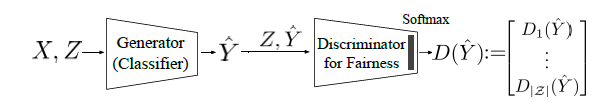

+ "FR-Train" 에서, discriminator의 loss를 정의하기 위해 아래와 같이 유도 했었다.

+ The discriminator for fairness in FR-Train distinguishes predictions w.r.t. one sensitive group from those in the others.
+ Disparate impact intends the sensitive attribute to be independent of the model’s prediction, i.e., $I(Z;\hat{Y}) = 0$.

+ 여기서, $I(Z;\hat{Y}) = 0$ sensitive group Z가 Y^와 독립적이여햐 한다는 것이고, 내가 의도하는 importance (=sensitive)의 변화는 train dataset을 단위 기간 순서로 자른 N개의 Bucket 또는 어떤 시간 단위 순서의 조건에 대해 독립이여야 한다는 것.

+ 따라서,  N개의 bucket을 B라고 한다면, conditional mutual importance $I(Z;\hat{Y}|B) = 0$ 가 되어야 한다.
+ 또한, FR-Train 이나 상기 논문 "Mitigating Unwanted Biases with Adversarial Learning"과 본 연구의 큰 차이점은 인구통계학적인 Disparate impact, 즉 남/여, 흑인/백인의 직접적인 fairness를 다루는 것이 아닌, continous한 z,y의 변화하는 sensitiveness를 다루는 것이다.

+ 실험1은 MI를 직접 다루지 않고 대신 mse로 대체하여 코드를 구현했으므로 논리적인 비약이 있다고 본다.
+ 따라서, MI를 직접 최대화, 최소화 할 수 있는 방안으로 코드를 구현하여 실험해 본다.
+ 이때, MI는 학습에 의해 최적화 시켜야 하므로 MINE (Mutual Information Neural Estimation)를 적용한다.
+ 상기 실험1과 유사하여 I(y,z)은 최대화 하고 I(y^,z)은 최소화 되도록 한다.

## RF-Train 에서 도출한 loss function

 + For the loss function of the generator, we employ cross entropy:

$$
\begin{align}
L_1= \dfrac{1}{m} \sum_{i=1}^{m} -y^{(i)} log \hat{y}^{(i)} - (1 - y^{(i)})log(1-\hat{y}^{(i)})
\end{align}
\tag{7}
$$
$$
\hat{I(\hat{Y},Z)} = \sup_{\theta \in \Theta} \mathbb{E}_{\mathbb{P}(n)_{\hat{Y}Z}}[T_{\theta}] - log(\mathbb{E}_{\mathbb{P}(n)_{\hat{Y}}\otimes \mathbb{\hat{P}}(n)_{Z}}[e^{T_{\theta}}] )
\tag{8}
$$

$$
L_2 = -I(Y,Z) + I(\hat{Y},Z)
\tag{9}
$$
여기서, $I$는 $\hat{I}를 의미한다. $
$$
\begin{align}
\min_{G(.)}L_1 + L_2 + std(L_1, L_2)
\end{align}
\tag{10}
$$

# 실험
+ synthetic data를 만든다.
+ 해당 data는 data drift가 시간에 따라 변화 된다.
+ 이때, 성능의 감소를 정량적으로 측정하고
+ Bucket을 고려한 몇개의 모델을 적용한다.

## synthetic data의 생성 (Case #1 MI의 감소, Drift의 증가 )



+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift

### Dataset 준비

In [304]:
data_size = 40000
cor = [1.5, 1.2, 0.9 , 0.7, 0.5]

In [305]:
seed_everything()
#y= np.random.normal(1,2,data_size)
y= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x[:,ix] = y + np.random.normal(1,cor_,data_size)
    #sns.scatterplot(x=x[:,ix],y=y)

In [306]:
seed_everything(100)

for i in range(400):
    s = i*100
    #x[s:s+100,3] = y[s:s+100] + np.random.normal(1,5-(i/100),100)
    x[s:s+100,4] = y[s:s+100] + np.random.normal(1,0.5+(i/100),100)
    #x[s:s+100,5] = i
#sns.scatterplot(x=x[0:200,4],y=y[0:200])
#sns.scatterplot(x=x[39800:40000,4],y=y[39800:40000])

### 실험

MI Analysis MI Max 0.20278, Min 0.02707, Mean 0.09885, Std 0.06305
Dataset structure X_train, (2000, 5) X_test, (2000, 5) X_live (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set (38, 2000, 5)


100%|██████████| 38/38 [00:01<00:00, 21.22it/s]


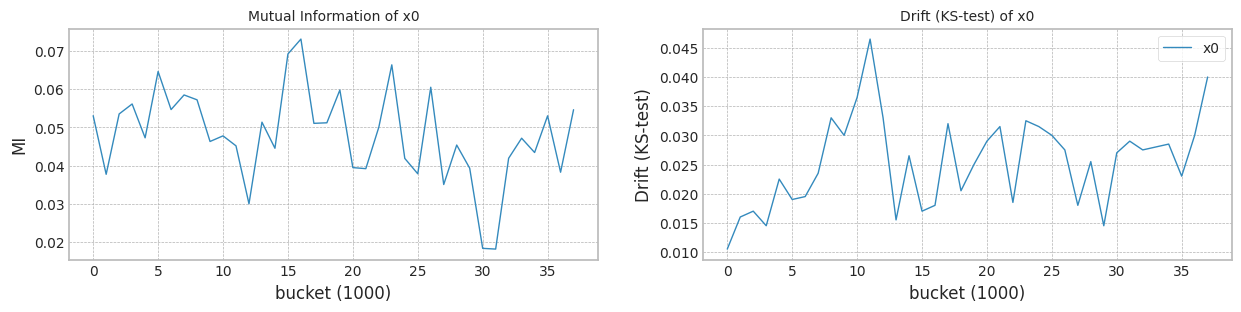

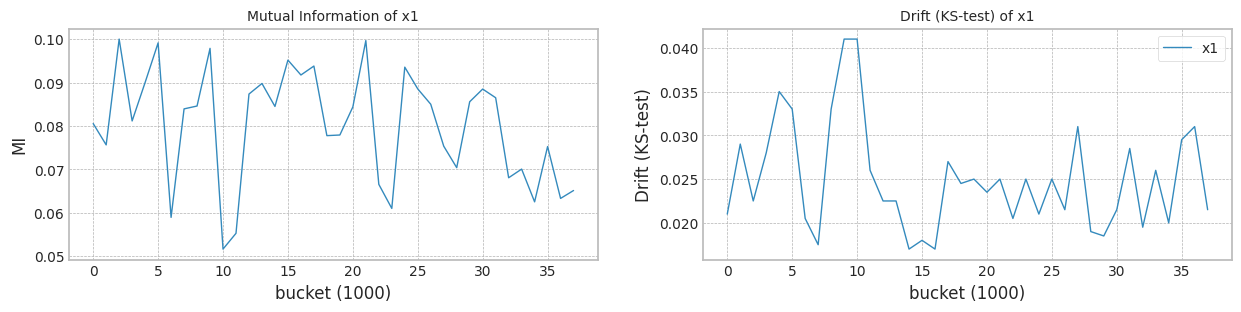

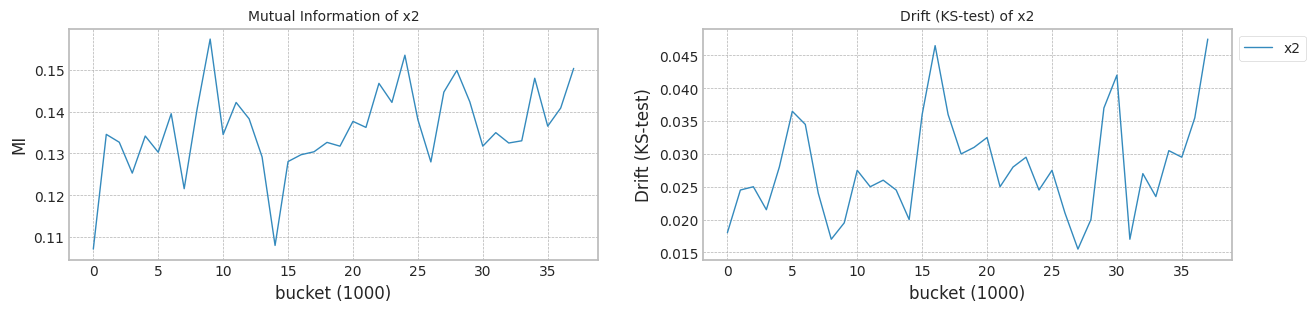

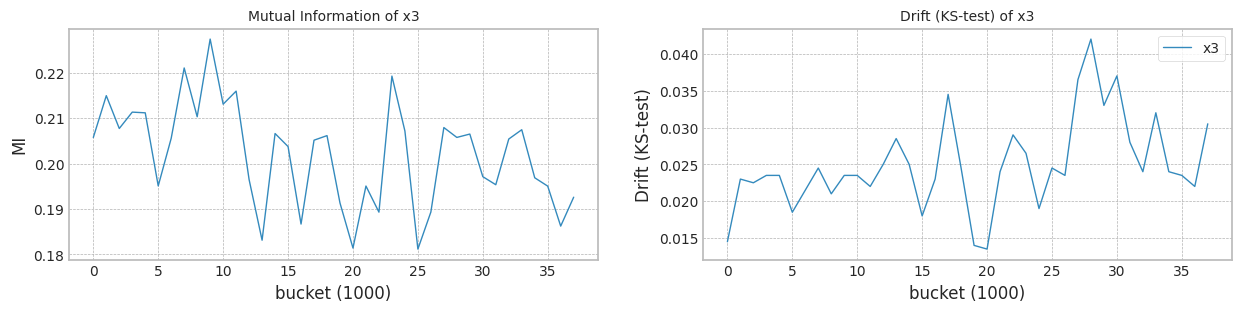

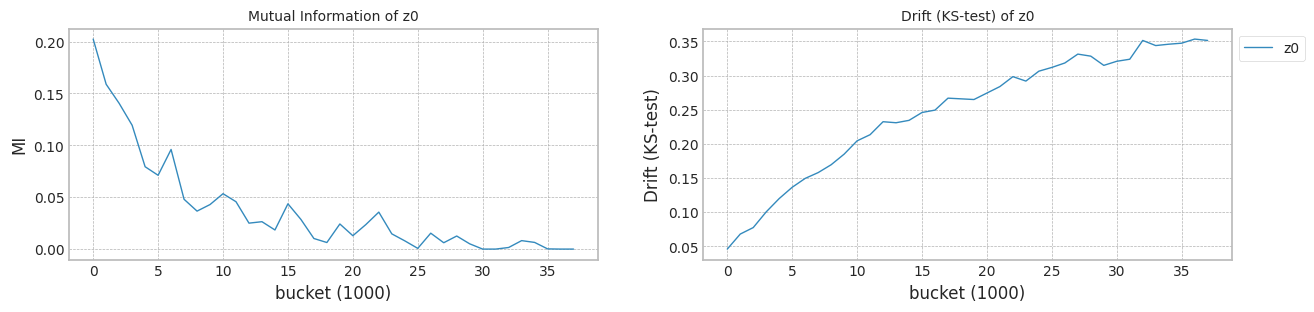

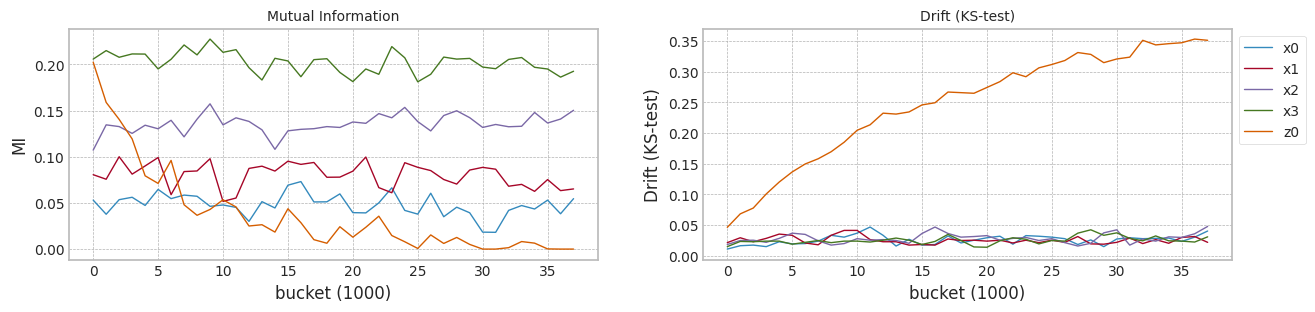

In [307]:
columns=['x0','x1','x2','x3','z0']
X = pd.DataFrame(x,columns=columns)
Y = y

train_size = 2000
test_size = 1000

X1,Y1 = check_mi_drift(X, Y,train_size, test_size)
#model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [308]:
X1

,x0,x1,x2,x3,z0
0,0.511187,0.348595,0.564807,0.482506,0.395084
1,0.435937,0.524656,0.595436,0.762536,0.606272
2,0.479071,0.682932,0.738867,0.596141,0.688060
3,0.572894,0.251745,0.392850,0.522275,0.344350
4,0.562890,0.613393,0.481594,0.596584,0.670729
...,...,...,...,...,...
39995,0.332800,0.214564,0.468946,0.614324,-0.069684
39996,0.414601,0.252607,0.438192,0.601093,0.984518
39997,0.361400,0.558191,0.590386,0.612855,0.528420
39998,0.459619,0.212723,0.148134,0.664097,2.043499


In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 400) #np.max(X1['b']+1))

trial_count: 20
lambda_f2 1.0
######################### Trial 0 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:07<00:00, 502.68it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 21.65it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 0 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:17<00:00, 222.33it/s]


Test f1 score: 0.8611361587015328
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.29it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.781330389637998
Normal model mean        : 0.7014876494674191
Drift tolerant model mean: 0.781330389637998
######################### Trial 1 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:06<00:00, 632.78it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.85it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 1 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 244.94it/s]


Test f1 score: 0.8684089867033471
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:02<00:00, 16.11it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.773618516222343
Normal model mean        : 0.7014876494674191
Drift tolerant model mean: 0.7774744529301705
######################### Trial 2 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 701.47it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.55it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 2 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 245.89it/s]


Test f1 score: 0.871342313051556
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:02<00:00, 17.11it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7775790981077813
Normal model mean        : 0.7014876494674191
Drift tolerant model mean: 0.7775093346560408
######################### Trial 3 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 744.66it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.64it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 3 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 249.09it/s]


Test f1 score: 0.8665430954587581
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:02<00:00, 18.79it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7850519650598448
Normal model mean        : 0.7014876494674191
Drift tolerant model mean: 0.7793949922569917
######################### Trial 4 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 748.75it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.76it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 4 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 243.22it/s]


Test f1 score: 0.8748255002326664
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.05it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7735162371927037
Normal model mean        : 0.7014876494674191
Drift tolerant model mean: 0.7782192412441341
######################### Trial 5 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 756.75it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 19.74it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 5 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:17<00:00, 234.65it/s]


Test f1 score: 0.8600182982616652
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 19.53it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7955315323157791
Normal model mean        : 0.7014876494674191
Drift tolerant model mean: 0.7811046230894082
######################### Trial 6 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 771.83it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.73it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 6 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 245.10it/s]


Test f1 score: 0.8592321755027423
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 21.26it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.797232611096628
Normal model mean        : 0.7014876494674193
Drift tolerant model mean: 0.7834086213761539
######################### Trial 7 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 756.02it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.21it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 7 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 244.51it/s]


Test f1 score: 0.854413102820746
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.64it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.8166752372235411
Normal model mean        : 0.7014876494674191
Drift tolerant model mean: 0.7875669483570773
######################### Trial 8 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 760.65it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.65it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 8 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 244.56it/s]


Test f1 score: 0.859109683340982
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.17it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.8052165073016202
Normal model mean        : 0.7014876494674191
Drift tolerant model mean: 0.7895280104620265
######################### Trial 9 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 761.36it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.75it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 9 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 238.11it/s]


Test f1 score: 0.848404255319149
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.48it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7973796667659623
Normal model mean        : 0.701487649467419
Drift tolerant model mean: 0.79031317609242
######################### Trial 10 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 760.22it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.68it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 10 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 241.71it/s]


Test f1 score: 0.8618983355825461
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.37it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7793486356832932
Normal model mean        : 0.701487649467419
Drift tolerant model mean: 0.7893163996915903
######################### Trial 11 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 742.41it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 20.52it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 11 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 245.14it/s]


Test f1 score: 0.863063063063063
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 21.96it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7679432502048986
Normal model mean        : 0.701487649467419
Drift tolerant model mean: 0.7875353039010328
######################### Trial 12 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 763.82it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:02<00:00, 18.52it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 12 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:16<00:00, 246.36it/s]


Test f1 score: 0.8613861386138613
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.85it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.786347531378191
Normal model mean        : 0.7014876494674189
Drift tolerant model mean: 0.787443936783891
######################### Trial 13 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 759.72it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:02<00:00, 16.08it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 13 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 251.88it/s]


Test f1 score: 0.858044164037855
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.47it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7941882385016108
Normal model mean        : 0.7014876494674189
Drift tolerant model mean: 0.7879256726208711
######################### Trial 14 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 740.35it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:02<00:00, 15.62it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 14 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 255.87it/s]


Test f1 score: 0.855475763016158
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.55it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7943554808932254
Normal model mean        : 0.7014876494674189
Drift tolerant model mean: 0.7883543265056947
######################### Trial 15 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 724.44it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:02<00:00, 17.16it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 15 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 257.25it/s]


Test f1 score: 0.7823426573426573
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.03it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7926667969968845
Normal model mean        : 0.7014876494674191
Drift tolerant model mean: 0.7886238559113941
######################### Trial 16 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 705.28it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:02<00:00, 18.87it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 16 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 255.44it/s]


Test f1 score: 0.8663930688554491
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.57it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7795944877323248
Normal model mean        : 0.7014876494674191
Drift tolerant model mean: 0.788092716606743
######################### Trial 17 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 690.85it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 20.53it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 17 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 258.01it/s]


Test f1 score: 0.855981941309255
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 21.90it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.8014120614926226
Normal model mean        : 0.7014876494674191
Drift tolerant model mean: 0.7888326802115141
######################### Trial 18 for Normal model ###########################
cpu


100%|██████████| 4000/4000 [00:05<00:00, 668.28it/s]


Test f1 score: 0.8869395711500975
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.30it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7014876494674191
######################### Trial 18 for Drift tolerant model ###########################
cpu


100%|██████████| 4000/4000 [00:15<00:00, 257.26it/s]


Test f1 score: 0.8565062388591801
X_live.shape (39000, 5)
Truncate 1000 rows from live_set (39000, 5)
Search MI & Drift...for X_live_set torch.Size([38, 2000, 5])


100%|██████████| 38/38 [00:01<00:00, 22.58it/s]


mean of drift:
x0    0.025474
x1    0.024961
x2    0.028013
x3    0.024921
z0    0.247908
dtype: float64
Mean F1 for all data: 0.7915006281898728
Normal model mean        : 0.701487649467419
Drift tolerant model mean: 0.7889730985261645
######################### Trial 19 for Normal model ###########################
cpu


 70%|███████   | 2819/4000 [00:03<00:02, 522.84it/s]

## synthetic data의 생성 (Case #2 MI의 증감(상대적), Drift의 고정)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature에 대해 y의 비중이 시간에 따라 감소하도록 생성

### Dataset 준비

In [ ]:
data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 2.5])

In [ ]:
seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

In [ ]:
import matplotlib.pyplot as plt

seed_everything()

y1_array = []
cor_const = cor[4]
for ii in range(x1.shape[0]):
    cor[4] = cor[4] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    y1_array.append(np.sum(cor * x1[ii])+e)

In [ ]:
m = 5 #np.mean(y1_array[0:2000])
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
print(sum(y1))

### 실험

In [ ]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 2000
test_size = 1000

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)
#model,df = train_classificaion_model(X1,Y1,train_size, test_size)

In [ ]:
X1

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #3 MI의 증감(상대적), Drift의 증가)

+ 5개의 feature
+ 각각 importance를 부여
+ 그 중, 1개의 feature는 가변 data drift, MI는 고정

### Dataset 준비

In [ ]:
import matplotlib.pyplot as plt

cor = np.asarray([2.5, 1.2, 0.9 , 0.7, 1.5])

seed_everything()

x1 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    x1[:,ix] = np.random.normal(1,cor_,data_size)

seed_everything()

y1_array = []
cor_const = cor[0]
for ii in range(x1.shape[0]):
    #cor[0] = cor[0] - cor_const / x1.shape[0]
    e = np.random.normal(0.0, 2.0)
    e1 = np.random.normal(0.0,  4*ii/40000)
    x1[ii,4] = x1[ii,4] + e1
    y1_array.append(np.sum(cor * x1[ii])+e)

In [ ]:
m = np.mean(y1_array)
print(m)
y1 = [1 if y_ > m else 0 for y_ in y1_array]
sum(y1)

### 실험

In [ ]:
columns=['x0','x1','x2','x3','z0']
X1 = pd.DataFrame(x1,columns=columns)

train_size = 2000
test_size = 1000

X1,Y1 = check_mi_drift(X1, y1,train_size, test_size)

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))


## synthetic data의 생성 (Case #4 MI의 고정, Drift의 증가)

### Dataset 준비

In [ ]:
seed_everything()

data_size = 40000
cor = np.asarray([1.5, 1.2, 0.9 , 0.7, 0.5])

y3= (np.random.normal(0.5,0.5,data_size) > 0.5).astype(int)
x3 = np.zeros((data_size,5))
for ix,cor_ in enumerate(cor):
    '''
    x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)
    '''
    # z0
    if ix == 4:
        for ii in range(len(y3)):
            x3[ii,ix] = y3[ii] + np.random.normal(0.0 + 4*ii/data_size,cor_)
    else:
        x3[:,ix] = y3 + np.random.normal(1,cor_,data_size)


### 실험

In [ ]:
columns=['x0','x1','x2','x3','z0']
X3 = pd.DataFrame(x3,columns=columns)

train_size = 2000
test_size = 1000

X1,Y1 = check_mi_drift(X3, y3,train_size, test_size)

In [ ]:
_,_,_,_,_,_ = drift_tolerant(X1, Y1,train_size, test_size,avaible_range = 100) #np.max(X1['b']+1))
